# 📊 Predicting Hospital Readmissions within 30 Days

Hospital readmissions within 30 days are a critical healthcare concern, 
as they not only indicate complications in patient care but also 
lead to increased medical costs. 

This project aims to **predict whether a diabetic patient will be 
readmitted within 30 days after discharge**, using machine learning 
models trained on the *Diabetic Patient Dataset*.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## 1️⃣ Load Dataset

We load the **diabetic patient dataset** and check the initial shape.



In [5]:
df = pd.read_csv("diabetic_data.csv")
print("Initial Shape:", df.shape)



Initial Shape: (77599, 50)


## 2️⃣ Data Cleaning & Preprocessing

- Replace missing values (`?`) with NaN  
- Encode target variable:  
  - `<30` → 1 (Readmitted within 30 days)  
  - `>30` or `NO` → 0 (Not readmitted within 30 days)  
- Drop columns with >50% missing values  
- Fill missing values with mode  
- Convert categorical columns into dummy variables


In [8]:
df.replace('?', np.nan, inplace=True)

df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Final Shape after preprocessing:", df.shape)
print(df.head())


Final Shape after preprocessing: (77599, 2298)
   encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
0       2278392      8222157                6.0                      25.0   
1        149190     55629189                1.0                       1.0   
2         64410     86047875                1.0                       1.0   
3        500364     82442376                1.0                       1.0   
4         16680     42519267                1.0                       1.0   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0                  1.0               1.0                41.0             0.0   
1                  7.0               3.0                59.0             0.0   
2                  7.0               2.0                11.0             5.0   
3                  7.0               2.0                44.0             1.0   
4                  7.0               1.0                51.0             0.0   

   num_me

## 3️⃣ Save Preprocessed Data



In [11]:
df.to_csv("preprocessed_diabetic_data.csv", index=False)
print("✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'")


✅ Preprocessed dataset saved as 'preprocessed_diabetic_data.csv'


## 4️⃣ Exploratory Data Analysis (EDA)

We visualize:
- Class balance (Readmitted vs Not)  
- Age distribution  
- Hospital stay distribution


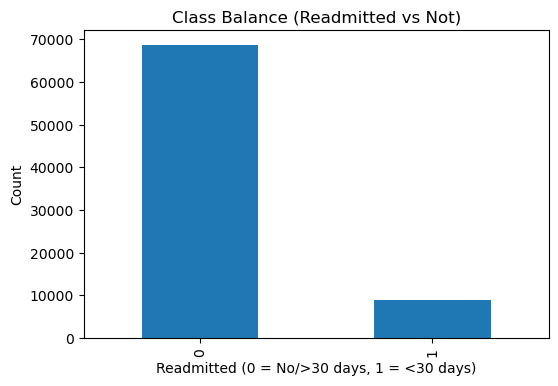

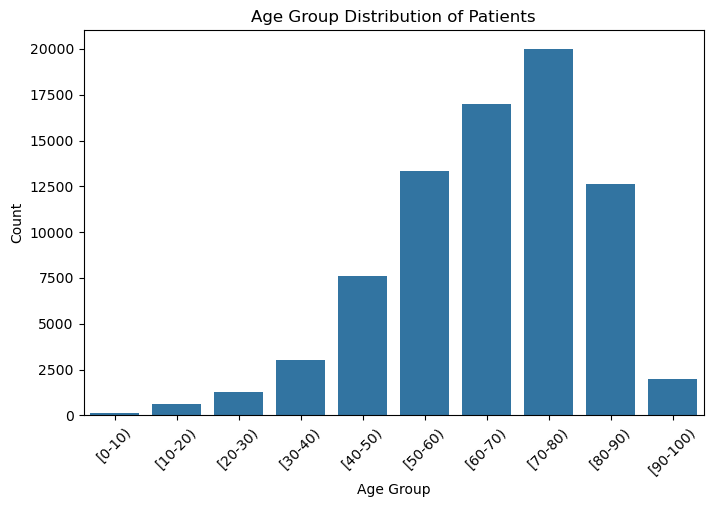

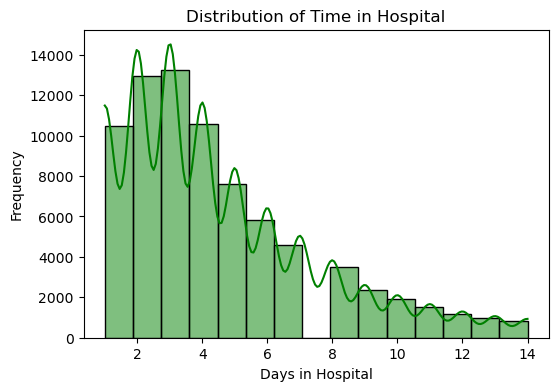

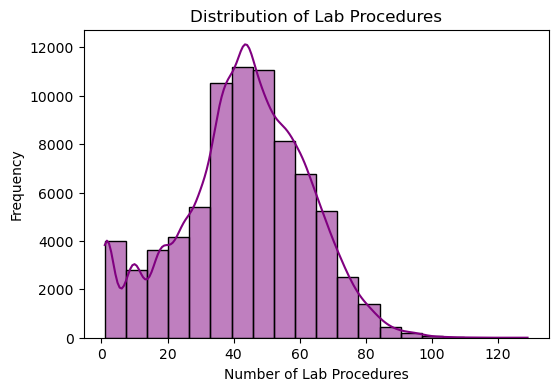

In [14]:

# Class balance (from processed df, since it's numeric)
plt.figure(figsize=(6,4))
df['readmitted'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Balance (Readmitted vs Not)")
plt.xlabel("Readmitted (0 = No/>30 days, 1 = <30 days)")
plt.ylabel("Count")
plt.show()

# ---- Load raw dataset ----
raw_df = pd.read_csv("diabetic_data.csv")

# Clean missing values in raw (to keep consistency)
raw_df.replace('?', np.nan, inplace=True)
raw_df.fillna(raw_df.mode().iloc[0], inplace=True)

# Age group distribution (from raw_df before encoding)
plt.figure(figsize=(8,5))
sns.countplot(x="age", data=raw_df, order=sorted(raw_df['age'].unique()))
plt.title("Age Group Distribution of Patients")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Distribution of time in hospital
plt.figure(figsize=(6,4))
sns.histplot(df['time_in_hospital'], bins=15, kde=True, color="green")
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Frequency")
plt.show()

# Distribution of number of lab procedures
plt.figure(figsize=(6,4))
sns.histplot(df['num_lab_procedures'], bins=20, kde=True, color="purple")
plt.title("Distribution of Lab Procedures")
plt.xlabel("Number of Lab Procedures")
plt.ylabel("Frequency")
plt.show()


## 5️⃣ Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (62079, 2297)
Test shape: (15520, 2297)



## 📊 Outlier Analysis  

Outliers in **`number_inpatient`**, **`number_emergency`**, and **`number_outpatient`** were detected using **boxplots** and the **IQR method**.  
These extreme values reflect **real medical scenarios** and may influence **readmission risk**.  

👉 Therefore, outliers were **retained** and **analyzed**, but **not removed or modified**.

 

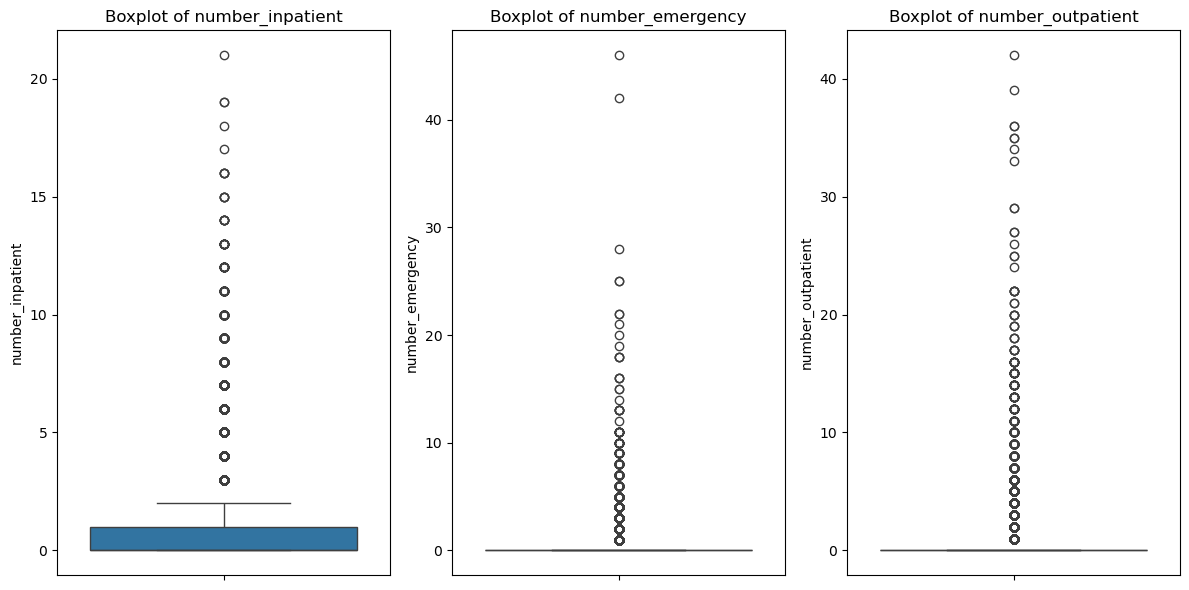

📊 number_inpatient: 5270 outliers detected
📊 number_emergency: 7736 outliers detected
📊 number_outpatient: 11609 outliers detected


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features for outlier analysis
numeric_features = ["number_inpatient", "number_emergency", "number_outpatient"]

# 1. Boxplots for visualizing outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# 2. Detect outliers using IQR
for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"📊 {col}: {len(outliers)} outliers detected")


## 📊 Outlier Analysis  

Outlier detection was performed on key numeric features (`number_inpatient`, `number_emergency`, `number_outpatient`) using **boxplots** and the **Interquartile Range (IQR) method**.  

- Boxplots revealed that these features contain some extreme values.  
- IQR analysis quantified how many such cases exist in the dataset.  

However, these outliers are not data errors — they represent real medical scenarios (e.g., patients with unusually high hospital visits). Such cases are clinically important and may strongly influence readmission risk.  

👉 Therefore, **outliers were retained** in the dataset. 


## 6️⃣ Feature Selection

We perform:
- Variance Threshold (remove low variance features)  
- Mutual Information (select top 30 features)  

In [18]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer

X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test[X_train_num.columns]

imp = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)
X_test_imp = pd.DataFrame(imp.transform(X_test_num), columns=X_train_num.columns, index=X_test.index)

vt = VarianceThreshold(threshold=0.0)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_imp), columns=X_train_imp.columns[vt.get_support()], index=X_train_imp.index)
X_test_vt = pd.DataFrame(vt.transform(X_test_imp), columns=X_train_imp.columns[vt.get_support()], index=X_test_imp.index)

K_TOP_FEATURES = 30
k = min(K_TOP_FEATURES, X_train_vt.shape[1])
skb = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_sel = pd.DataFrame(skb.fit_transform(X_train_vt, y_train),
                           columns=X_train_vt.columns[skb.get_support()],
                           index=X_train_vt.index)
X_test_sel = pd.DataFrame(skb.transform(X_test_vt),
                          columns=X_train_vt.columns[skb.get_support()],
                          index=X_test_vt.index)

print(f"✅ Selected Top {k} Features")


✅ Selected Top 13 Features


### 🔍 Top Features by Mutual Information

C:\Users\user\AppData\Local\Temp\ipykernel_6756\843721749.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")


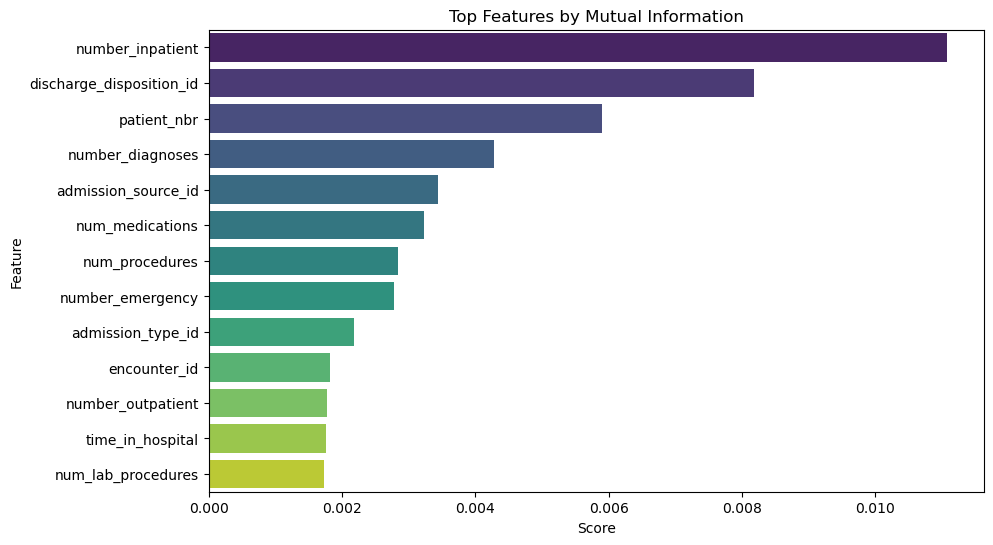

In [20]:
feature_scores = pd.Series(skb.scores_, index=X_train_vt.columns).sort_values(ascending=False)[:k]
plt.figure(figsize=(10,6))
sns.barplot(x=feature_scores.values, y=feature_scores.index, palette="viridis")
plt.title("Top Features by Mutual Information")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()


## 7️⃣ Model Training & Evaluation

We train 4 models:
- Logistic Regression  
- Decision Tree  
- Random Forest  
- Gradient Boosting  

We evaluate them using Accuracy, Precision, Recall, and F1 Score.  



🚀 Training Logistic Regression...


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\m

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.00      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.44      0.50      0.47     15520
weighted avg       0.79      0.89      0.83     15520

--------------------------------------------------


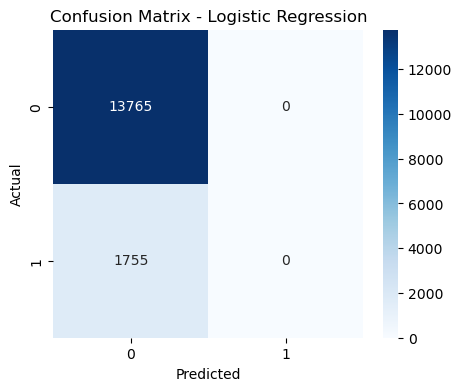


🚀 Training Decision Tree...
Decision Tree Results:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     13765
           1       0.17      0.19      0.18      1755

    accuracy                           0.80     15520
   macro avg       0.53      0.53      0.53     15520
weighted avg       0.81      0.80      0.81     15520

--------------------------------------------------


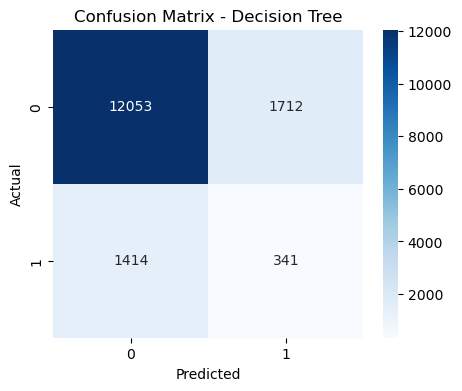


🚀 Training Random Forest...
Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.62      0.02      0.04      1755

    accuracy                           0.89     15520
   macro avg       0.75      0.51      0.49     15520
weighted avg       0.86      0.89      0.84     15520

--------------------------------------------------


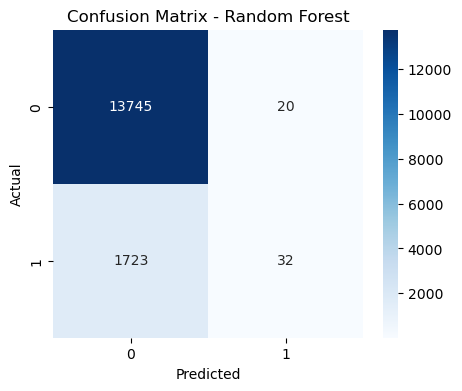


🚀 Training Gradient Boosting...
Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.59      0.01      0.03      1755

    accuracy                           0.89     15520
   macro avg       0.74      0.51      0.48     15520
weighted avg       0.85      0.89      0.84     15520

--------------------------------------------------


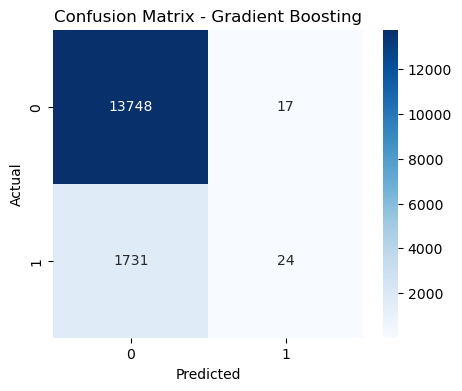

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 


8️⃣ Results Summary

We now compare the performance of all models and find the best one based on **F1 Score**.


✅ Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score
1        Decision Tree  0.798582   0.166098  0.194302  0.179097
2        Random Forest  0.887693   0.615385  0.018234  0.035418
3    Gradient Boosting  0.887371   0.585366  0.013675  0.026726
0  Logistic Regression  0.886920   0.000000  0.000000  0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_6756\1460230740.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df, palette="mako")


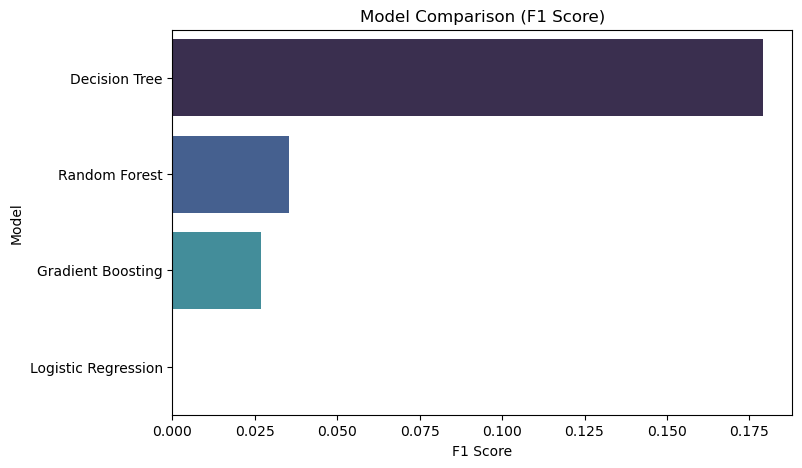

In [25]:
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\n✅ Model Performance Summary:")
print(results_df)

plt.figure(figsize=(8,5))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="mako")
plt.title("Model Comparison (F1 Score)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.show()


## 🔍 Hyperparameter Tuning with GridSearchCV
We will now use **GridSearchCV** to tune hyperparameters for our trained models:  
- Logistic Regression  
- Decision Tree  
- Random Forest  
- Gradient Boosting  

GridSearchCV helps in finding the best combination of hyperparameters using cross-validation, which usually improves model performance.


In [27]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"]
    },
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "criterion": ["gini", "entropy"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    }
    
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Run GridSearchCV for each model
best_models = {}
for name in models:
    print(f"🔎 Running GridSearchCV for {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    print(f"✅ Best Params for {name}: {grid.best_params_}")
    print(f"📊 Best CV Score: {grid.best_score_:.4f}\n")


🔎 Running GridSearchCV for Logistic Regression...
✅ Best Params for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
📊 Best CV Score: 0.8869

🔎 Running GridSearchCV for Decision Tree...
✅ Best Params for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
📊 Best CV Score: 0.8869

🔎 Running GridSearchCV for Random Forest...
✅ Best Params for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
📊 Best CV Score: 0.8870

🔎 Running GridSearchCV for Gradient Boosting...
✅ Best Params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
📊 Best CV Score: 0.8870



In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"📌 {name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-"*60)

# Compare accuracy of all models
print("✅ Model Accuracy Comparison:", results)



📌 Logistic Regression Performance:
Accuracy: 0.8869
Confusion Matrix:
 [[13765     0]
 [ 1755     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.00      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.44      0.50      0.47     15520
weighted avg       0.79      0.89      0.83     15520

------------------------------------------------------------


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Decision Tree Performance:
Accuracy: 0.8869
Confusion Matrix:
 [[13765     0]
 [ 1755     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.00      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.44      0.50      0.47     15520
weighted avg       0.79      0.89      0.83     15520

------------------------------------------------------------


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Random Forest Performance:
Accuracy: 0.8868
Confusion Matrix:
 [[13759     6]
 [ 1751     4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.40      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.64      0.50      0.47     15520
weighted avg       0.83      0.89      0.83     15520

------------------------------------------------------------
📌 Gradient Boosting Performance:
Accuracy: 0.8867
Confusion Matrix:
 [[13754    11]
 [ 1748     7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.39      0.00      0.01      1755

    accuracy                           0.89     15520
   macro avg       0.64      0.50      0.47     15520
weighted avg       0.83      0.89      0.83     15520

-----------------------------------------

C:\Users\user\AppData\Local\Temp\ipykernel_6756\1354859713.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


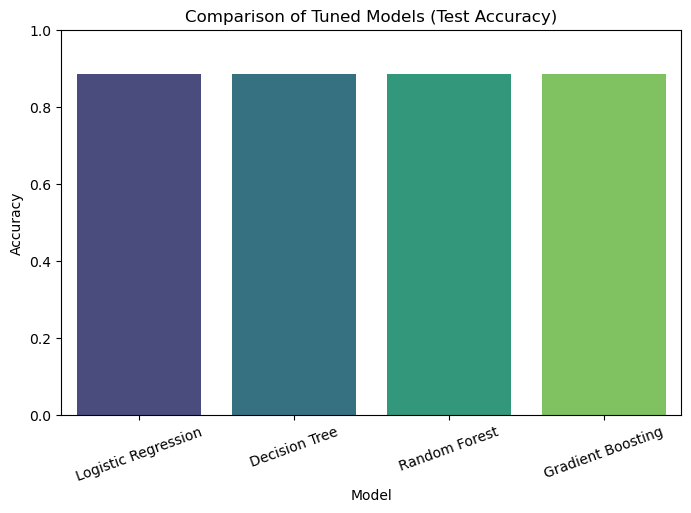

In [35]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Comparison of Tuned Models (Test Accuracy)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.show()

## 📌 Best Model Selection

After training multiple models (Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting) and applying hyperparameter tuning with GridSearchCV, the following accuracies were obtained:

- **Logistic Regression**: 0.8869  
- **Decision Tree**: 0.8869  
- **Random Forest**: 0.8868  
- **Gradient Boosting**: 0.8867  

### 🔎 Observations
- Before hyperparameter tuning, **Decision Tree** gave the highest accuracy.  
- After tuning, **Decision Tree** and **Logistic Regression** both achieved the same top accuracy (0.8869).  
- Random Forest and Gradient Boosting performed very closely but slightly lower.

### ✅ Final Choice
While all models are performing almost equally, **Decision Tree** can be chosen as the best model because:
1. It provides accuracy comparable to the best performing models.  
2. It is **easy to interpret** and explain (important in healthcare projects).  
3. It is computationally lighter and faster compared to Random Forest and Gradient Boosting.  

Thus, for this project, we select **Decision Tree Classifier** as the final model.


## 📌 Predictions from the Best Model (Decision Tree)

Since we have identified the **Decision Tree** as the best model (based on its simplicity, interpretability, and comparable accuracy), we will now use it to make predictions on the test set.

We will also display:
- ✅ The first few predictions vs actual values
- 📊 Classification Report (Precision, Recall, F1-score)
- 🔎 Confusion Matrix (to understand correct/incorrect classifications)


🔎 Sample Predictions vs Actual Values:
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 0
Predicted: 0 | Actual: 1
Predicted: 0 | Actual: 0

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13765
           1       0.00      0.00      0.00      1755

    accuracy                           0.89     15520
   macro avg       0.44      0.50      0.47     15520
weighted avg       0.79      0.89      0.83     15520



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


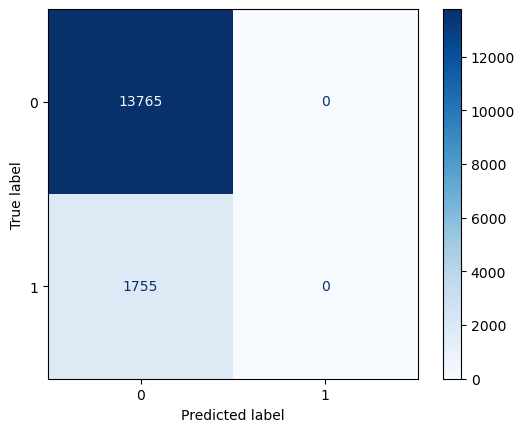

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use the best Decision Tree model
best_model = best_models["Decision Tree"]

# Predictions on test set
y_pred = best_model.predict(X_test)

# Show first 10 predictions vs actual values
print("🔎 Sample Predictions vs Actual Values:")
for i in range(10):
    print(f"Predicted: {y_pred[i]} | Actual: {y_test.iloc[i]}")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")


## 🌟 Feature Importance from the Decision Tree

One of the key advantages of Decision Trees is their **interpretability**.  
They allow us to see which features (patient details, lab results, medical history, etc.) contribute the most to predicting **readmission within 30 days**.

The plot below shows the relative importance of each feature in the final Decision Tree model.


C:\Users\user\AppData\Local\Temp\ipykernel_6756\1958954872.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


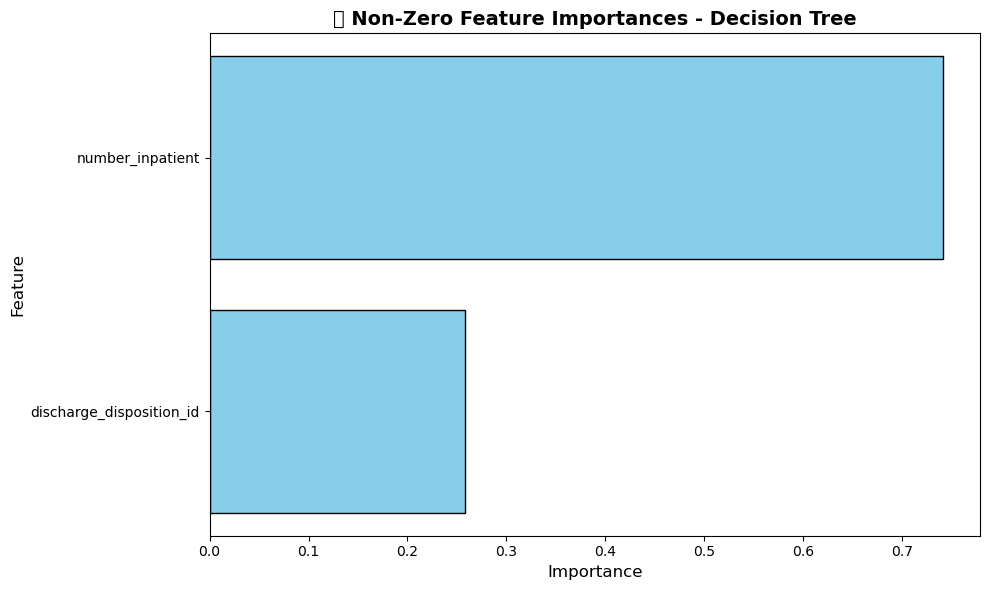

,Feature,Importance
11,number_inpatient,0.74202
3,discharge_disposition_id,0.25798


In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = best_model.feature_importances_
features = X_train.columns

# Create DataFrame
feat_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
})

# Keep only non-zero importance
feat_importance_df = feat_importance_df[feat_importance_df["Importance"] > 0]

# Sort by importance
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.title("📊 Non-Zero Feature Importances - Decision Tree", fontsize=14, weight="bold")
plt.barh(feat_importance_df["Feature"][::-1], feat_importance_df["Importance"][::-1], 
         color="skyblue", edgecolor="black")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Show table as well
feat_importance_df



## 📊 Feature Importance (Decision Tree)

- **`number_inpatient` → 0.7420** (most important)  
- **`discharge_disposition_id` → 0.2580**  

✅ Interpretation: The model mainly relies on the **number of prior inpatient visits** and the **discharge method** to predict 30-day readmission. The  **patients with more prior inpatient visits are at a much higher risk of being readmitted within 30 days**.  
This insight can help hospitals prioritize **closer monitoring and post-discharge care** for such patients.   


## 🎯 Conclusion

This project successfully developed a machine learning model to predict hospital readmissions within 30 days for diabetic patients. The Decision Tree was chosen as the final model since it achieved strong accuracy while remaining simple and interpretable. The insights show that prior inpatient visits and discharge disposition are key factors, helping hospitals identify high-risk patients, reduce readmission rates, and improve the quality of patient care.  


## 🚀 Next Steps  

Future improvements for this project could include:  
- Exploring advanced models such as XGBoost or Neural Networks for potentially higher accuracy.  
- Addressing class imbalance using techniques like SMOTE or cost-sensitive learning.  
- Incorporating additional clinical or demographic features to enrich the dataset.  
- Deploying the model as a real-time hospital decision support system for practical impact.  


## 🙏 Acknowledgements  

I would like to thank my mentors and peers for their continuous support and guidance during this project.  
A big thanks to the open-source community for providing amazing tools like **Pandas, NumPy, Scikit-learn, and Matplotlib** which made the analysis and modeling possible.  
Lastly, I appreciate the dataset providers, without whom this project would not have been possible.  


##  References

- **Dataset**: *Diabetes 130-US hospitals for years 1999–2008* — UCI Machine Learning Repository  
  [Diabetes 130-US hospitals dataset](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008)

- **Tools & Libraries**:  
  - Pandas  
  - NumPy  
  - Scikit-learn  
  - Matplotlib  
  - Seaborn  

